# Calculating Expected Threat (xT)

This notebook follows the works and steps of Karun Singh in his [blog](https://karun.in/blog/expected-threat.html) outlining his expected threat (xT) idea.

Further things to do:
- So far only look at moving from zone to zone with passes. Should also include carries and dribbles. Then can determine how players generate Threat.
- How to handle negative xT numbers?

In [1]:
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

import importing_sb as imsb
import draw_pitch as dp

plt.style.use("football")

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_dir = 'data/open-data/data/'

comp_data = imsb.open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(imsb.open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

In [4]:
match_ids_18 = pd.DataFrame(match_data[0])['match_id'].to_numpy()

In [5]:
event_data_18 = []
for match in match_ids_18:
        event_data_18.append(imsb.open_data(data_dir + 'events/{}.json'.format(str(match))))

In [6]:
event_data_18 = [i for match in event_data_18 for i in match]

In [8]:
df_shot = imsb.get_shots(event_data_18)
df_shot = df_shot[df_shot['team'] == 'Barcelona'].copy()
df_shot = df_shot[df_shot['shot_type'] == 'Open Play'].copy()
df_shot['y'] = 80 - df_shot['y']
df_shot['end_y'] = 80 - df_shot['end_y']

In [9]:
df_shot.head()

,index,event_id,period,minute,second,type,pos_team,play_pattern,team,player,x,y,duration,under_pressure,end_x,end_y,end_z,follows_dribble,first_time,freeze_frame,open_goal,sb_xg,deflection,technique,body_part,shot_type,outcome
0,148,65f16e50-7c5d-4293-b2fc-d20887a772f9,1,2,29,Shot,Barcelona,Regular Play,Barcelona,Lionel Andrés Messi Cuccittini,111.7,28.3,0.773778,False,120.0,47.3,0.2,False,True,"[{'location': [103.7, 44.1], 'player': {'id': ...",False,0.095480,False,Half Volley,Right Foot,Open Play,Off T
1,283,b0f73423-3990-45ae-9dda-3512c2d1aff3,1,5,39,Shot,Barcelona,Regular Play,Barcelona,Jordi Alba Ramos,114.0,53.0,0.653182,False,120.0,45.0,0.9,False,True,"[{'location': [112.8, 30.5], 'player': {'id': ...",False,0.047924,False,Volley,Left Foot,Open Play,Off T
2,755,13b1ddab-d22e-43d9-bfe4-12632fea1a27,1,15,28,Shot,Barcelona,From Keeper,Barcelona,Lionel Andrés Messi Cuccittini,92.0,45.5,1.033587,False,117.8,41.5,0.4,False,False,"[{'location': [117.9, 39.8], 'player': {'id': ...",False,0.018477,False,Normal,Left Foot,Open Play,Saved
4,842,5e55f5a5-954f-4cc4-ba6e-a9cf6d6e249e,1,18,15,Shot,Barcelona,From Corner,Barcelona,Luis Alberto Suárez Díaz,107.0,55.0,1.292568,False,120.0,37.5,3.8,False,False,"[{'location': [109.7, 26.8], 'player': {'id': ...",False,0.036229,False,Normal,Right Foot,Open Play,Off T
5,1395,1c0347cd-14dc-4aa8-91eb-520672a6cfe1,1,30,42,Shot,Barcelona,Regular Play,Barcelona,Ousmane Dembélé,108.1,52.6,2.209495,True,120.0,21.4,0.2,False,True,"[{'location': [91.4, 53.0], 'player': {'id': 6...",False,0.081458,False,Half Volley,Left Foot,Open Play,Off T


In [10]:
df_pass = imsb.get_pass(event_data_18)
df_pass = df_pass[df_pass['team'] == 'Barcelona'].copy()
df_pass = df_pass[df_pass['pass_type'] == 'Standard'].copy()
df_pass['y'] = 80 - df_pass['y']
df_pass['end_y'] = 80 - df_pass['end_y']

In [11]:
df_pass.head()

,index,event_id,period,minute,second,type,pos_team,play_pattern,team,player,x,y,end_x,end_y,length,angle,height,duration,recipient,under_pressure,cross,cutback,switch,shot_assist,goal_assist,xA,body_part,pass_type,outcome,technique,progressive
3,12,f774571f-4b65-43a0-9bfc-6384948d1b82,1,0,8,Pass,Barcelona,Regular Play,Barcelona,Ivan Rakitić,36.0,59.0,36.0,78.0,19.000000,-1.570796,Low Pass,1.145,Ousmane Dembélé,False,False,False,False,None,None,NaN,Head,Standard,Complete,None,False
4,16,46f0e871-3e72-4817-9a53-af27583ba6c1,1,0,10,Pass,Barcelona,Regular Play,Barcelona,Ousmane Dembélé,34.0,77.0,26.0,78.0,8.062258,-3.017238,Ground Pass,0.717,Jordi Alba Ramos,True,False,False,False,None,None,NaN,Right Foot,Standard,Complete,None,False
5,18,719bbdb1-8743-4c95-b5a5-b61a0c392741,1,0,11,Pass,Barcelona,Regular Play,Barcelona,Jordi Alba Ramos,25.0,78.0,94.0,60.0,71.309190,0.255182,High Pass,4.593,Luis Alberto Suárez Díaz,False,False,False,False,None,None,NaN,Left Foot,Standard,Incomplete,None,True
7,26,df65f591-1131-4565-ad3c-7295ccdf3f26,1,0,30,Pass,Barcelona,Regular Play,Barcelona,Marc-André ter Stegen,14.0,52.0,23.0,36.0,18.357560,1.058407,Ground Pass,1.758,Gerard Piqué Bernabéu,False,False,False,False,None,None,NaN,Keeper Arm,Standard,Complete,None,False
8,29,9a0bd516-551c-4e12-832e-a85b92dffcff,1,0,34,Pass,Barcelona,Regular Play,Barcelona,Gerard Piqué Bernabéu,35.0,26.0,44.0,8.0,20.124610,1.107149,Ground Pass,1.173,Nélson Cabral Semedo,False,False,False,False,None,None,NaN,Right Foot,Standard,Complete,None,False


In [12]:
pass_num, x_edge, y_edge, binnum = binned_statistic_2d(df_pass['x'].to_numpy(),df_pass['y'].to_numpy(), 
                                                   values=df_pass['x'].to_numpy(),
                                                   bins = (16,12), range = [[0,120],[0,80]],
                                                   statistic='count', expand_binnumbers=True)

In [13]:
shot_num, *_ = binned_statistic_2d(df_shot['x'].to_numpy(),df_shot['y'].to_numpy(), 
                                                   values=df_shot['x'].to_numpy(),
                                                   bins = (16,12), range = [[0,120],[0,80]],
                                                   statistic='count', expand_binnumbers=True)

In [14]:
df_pass['x_zone'] = pd.cut(df_pass['x'], x_edge).apply(lambda x: round(x.mid,2))
df_pass['y_zone'] = pd.cut(df_pass['y'], y_edge).apply(lambda x: round(x.mid,2))
df_pass['end_x_zone'] = pd.cut(df_pass['end_x'], x_edge).apply(lambda x: round(x.mid,2))
df_pass['end_y_zone'] = pd.cut(df_pass['end_y'], y_edge).apply(lambda x: round(x.mid,2))

In [15]:
df_shot['x_zone'] = pd.cut(df_shot['x'], x_edge).apply(lambda x: round(x.mid,2))
df_shot['y_zone'] = pd.cut(df_shot['y'], y_edge).apply(lambda x: round(x.mid,2))
df_shot['end_x_zone'] = pd.cut(df_shot['end_x'], x_edge).apply(lambda x: round(x.mid,2))
df_shot['end_y_zone'] = pd.cut(df_shot['end_y'], y_edge).apply(lambda x: round(x.mid,2))

In [16]:
df_shot.groupby(['x_zone','y_zone']).agg(num_shots=("index","count")).reset_index().pivot('x_zone','y_zone','num_shots')

y_zone,3.33,10.0,16.67,23.33,30.0,36.67,43.33,50.0,56.67,63.33,70.0,76.67
x_zone,,,,,,,,,,,,
3.75,0,0,0,0,0,0,0,0,0,0,0,0
11.25,0,0,0,0,0,0,0,0,0,0,0,0
18.75,0,0,0,0,0,0,0,0,0,0,0,0
26.25,0,0,0,0,0,0,0,0,0,0,0,0
33.75,0,0,0,0,0,0,0,0,0,0,0,0
41.25,0,0,0,0,0,0,0,0,0,0,0,0
48.75,0,0,0,0,0,0,0,0,0,0,0,0
56.25,0,0,0,0,0,0,0,0,0,0,0,0
63.75,0,0,0,1,0,0,0,0,0,0,0,0


In [17]:
x_grid, y_grid = np.meshgrid(x_edge,y_edge)

In [18]:
x_mid, y_mid = np.meshgrid(x_edge[:-1] + np.diff(x_edge) / 2, y_edge[:-1] + np.diff(y_edge) / 2)

In [19]:
iterables = [x_edge[:-1] + np.diff(x_edge) / 2, y_edge[:-1] + np.diff(y_edge) / 2]
index = pd.MultiIndex.from_product(iterables, names=['x_zone', 'y_zone'])
zone_num = pd.Series(np.arange(0,192,1), index=index, name='zone_num').reset_index()
zone_num = zone_num.round(2)

In [20]:
index = pd.MultiIndex.from_product(iterables, names=['end_x_zone', 'end_y_zone'])
end_zone_num = pd.Series(np.arange(0,192,1), index=index, name='end_zone_num').reset_index()
end_zone_num = end_zone_num.round(2)

In [21]:
df_pass = df_pass.merge(zone_num, on=['x_zone','y_zone'])
df_pass = df_pass.merge(end_zone_num, on=['end_x_zone','end_y_zone'])

In [22]:
df_shot = df_shot.merge(zone_num, on=['x_zone','y_zone'])
df_shot = df_shot.merge(end_zone_num, on=['end_x_zone','end_y_zone'])

In [23]:
zone_to_xy = zone_num.set_index(['zone_num'])

In [24]:
xy_to_zone = zone_num.set_index(['x_zone','y_zone'])

In [25]:
pass_from_to = df_pass.groupby(['zone_num','end_zone_num']).agg(num=("index","count"))
pass_from = df_pass.groupby(['zone_num']).agg(num=("index","count"))
shot_from = df_shot.groupby(['zone_num']).agg(num=("index","count"))

In [26]:
trans_matrix = pass_from_to.div(pass_from).reset_index().pivot('zone_num','end_zone_num','num').round(3).fillna(0)

In [27]:
df_zeros = pd.DataFrame(0, index=np.arange(192), columns=['num'])

In [28]:
num_total = shot_from.add(pass_from, fill_value=0)

In [29]:
shot_prob = shot_from.div(num_total, fill_value=0)

In [30]:
pass_prob = 1 - shot_prob

In [31]:
df_goal = df_shot[df_shot['outcome'] == 'Goal'].copy()

In [32]:
goal_from = df_goal.groupby(['zone_num']).agg(num=("index","count"))

In [33]:
goal_prob = goal_from.div(shot_from, fill_value=0)

In [34]:
goal_prob = goal_prob.add(df_zeros, fill_value=0)

In [35]:
trans_matrix

end_zone_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191
zone_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.118,0.059,0.059,0.000,0.059,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.118,0.059,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.118,0.118,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.059,0.059,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.059,0.000,0.000,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.059,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059,0.000,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
1,0.000,0.050,0.150,0.000,0.000,0.200,0.0,0.000,0.000,0.000,0.0,0.0,0.050,0.000,0.050,0.050,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.050,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.050,0.000,0.05,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.050,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050,0.000,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.05,0.100,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
2,0.043,0.043,0.043,0.087,0.261,0.087,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.043,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.130,0.000,0.0,0.000,0.043,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.087,0.043,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.043,0.043,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
3,0.000,0.000,0.000,0.000,0.071,0.107,0.0,0.036,0.036,0.000,0.0,0.0,0.036,0.036,0.107,0.071,0.036,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.036,0.000,0.0,0.036,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.036,0.036,0.071,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.036,0.036,0.036,0.036,0

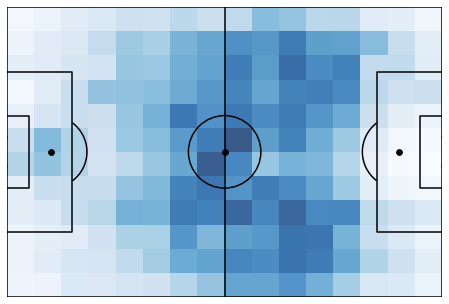

In [37]:
fig, ax = dp.draw_pitch('w','k','h','f',fig_width=8)

ax.imshow(pass_num.T, origin='lower', extent=(0,120,0,80), alpha=0.8, cmap='Blues')
ax.set_xlim(0,120)
ax.set_ylim(0,80)

plt.show()

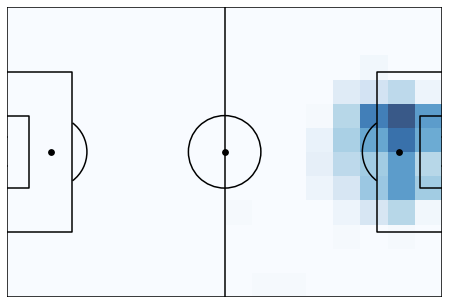

In [38]:
fig, ax = dp.draw_pitch('w','k','h','f',fig_width=8)

ax.imshow(shot_num.T, origin='lower', extent=(0,120,0,80), alpha=0.8, cmap='Blues')
ax.set_xlim(0,120)
ax.set_ylim(0,80)

plt.show()

## Expected Threat

$$
xT_{x,y} = (s_{x,y} \times g_{x,y}) + (m_{x,y} \times \sum_{z=1}^{16} \sum_{w=1}^{12} T_{(x,y)\to(z,w)} xT_{z,w})
$$

In [50]:
xT = pd.DataFrame(0, index=np.arange(192), columns=['xT0'])
for i in range(5):
    xT[f'xT{i+1}'] = (shot_prob['num'] * goal_prob['num']) + (pass_prob['num'] * (trans_matrix * xT[f'xT{i}']).sum(axis=1))

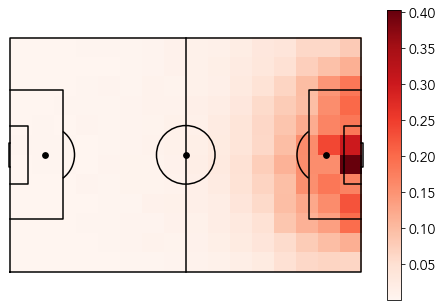

In [54]:
it = 'xT5'
test = zone_num.join(xT[it]).pivot('x_zone','y_zone',it).to_numpy()

fig,ax = dp.draw_pitch('w','k','h','f',fig_width=8)
im = ax.imshow(test.T, origin='lower', extent=[0,120,0,80], aspect='equal', cmap='Reds')
fig.colorbar(im, ax=ax)

plt.show()

## Where do Barcelona create the most xT from?

In [86]:
df_pass['xT'] = df_pass.apply(lambda x: xT['xT5'].loc[x['end_zone_num']] - xT['xT5'].loc[x['zone_num']],axis=1)

In [96]:
test = df_pass.groupby(['x_zone','y_zone'])['xT'].sum().reset_index().pivot('x_zone','y_zone','xT')

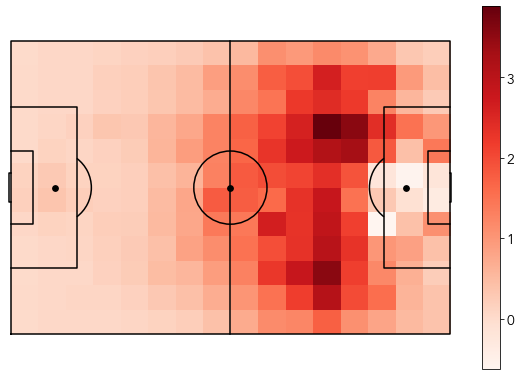

In [98]:
fig,ax = dp.draw_pitch('w','k','h','f',fig_width=10)
im = ax.imshow(test.T, origin='lower', extent=[0,120,0,80], aspect='equal', cmap='Reds')
fig.colorbar(im, ax=ax)

plt.show()

## Who created the most xT?

In [105]:
df_pass.groupby('player')['xT'].sum().sort_values(ascending=False)

player
Lionel Andrés Messi Cuccittini            46.196066
Jordi Alba Ramos                          23.936410
Ivan Rakitić                              21.364970
Sergio Busquets i Burgos                  12.939786
Ousmane Dembélé                           11.370302
Gerard Piqué Bernabéu                     10.734595
Philippe Coutinho Correia                  8.889056
Luis Alberto Suárez Díaz                   7.021848
Sergi Roberto Carnicer                     6.583375
Arthur Henrique Ramos de Oliveira Melo     5.951637
Arturo Erasmo Vidal Pardo                  4.913956
Clément Lenglet                            4.572105
Samuel Yves Umtiti                         3.408251
Nélson Cabral Semedo                       2.830927
Carles Aleña Castillo                      2.185392
Marc-André ter Stegen                      2.010465
Thomas Vermaelen                           1.254730
Malcom Filipe Silva de Oliveira            0.818609
Denis Suárez Fernández                     0.091072
Jaspe